# **Estudo Comparativo de Algoritmos Não Supervisionados**

# **1. Introdução**
Devido ao grande volume da base original, que contém `1.296.675` transações, os experimentos realizados neste notebook foram conduzidos utilizando apenas `1%` dos dados, o que corresponde a `12.966` transações.

A amostra foi selecionada de forma estratificada, preservando a proporção entre as classes da variável de interesse.

O arquivo correspondente a essa amostra reduzida encontra-se em:
`../data/processed/datasets/fraudTrain_processed_1pct.csv`

# **2. Carregamento dos Dados**

In [16]:
import pandas as pd

# A base após o processamento realizado no 
df = pd.read_csv('../data/processed/datasets/fraudTrain_processed_1pct.csv')
df.head()

,amt_scaled,city_pop_scaled,lat_scaled,long_scaled,gender_encoded_scaled,job_freq_scaled,category_freq_scaled,merchant_freq_scaled,cc_num_freq_scaled,age_scaled,hour_sin_scaled,hour_cos_scaled,weekday_sin_scaled,weekday_cos_scaled,month_sin_scaled,month_cos_scaled,is_weekend_scaled,unix_time_scaled,is_fraud
0,0.654418,1.027763,-2.417209,0.628139,-0.917333,0.831789,-0.636621,-0.347998,-1.071534,-1.082405,-0.183897,1.407365,-0.980643,0.693913,0.536755,1.300927,1.368821,-1.831134,0
1,-0.175756,-0.520683,-1.568082,-0.089643,-0.917333,-0.930478,-0.471992,-0.639424,0.230110,1.295796,-1.252684,0.042622,-1.262490,-0.501309,0.536755,1.300927,1.368821,0.624286,0
2,-0.438751,2.062678,-0.695547,-1.172463,-0.917333,-1.566852,0.942130,-0.347998,-1.308196,0.425723,0.189322,-1.370263,-0.980643,0.693913,1.080866,0.794618,1.368821,0.818498,0
3,-0.209715,0.404699,0.096131,-2.361068,-0.917333,1.761874,-0.577523,-0.202285,1.058428,0.019688,-0.183897,-1.322121,1.583558,-0.501309,0.536755,1.300927,-0.730556,-1.766555,0
4,0.113120,-0.723517,-0.029814,1.096284,-0.917333,-0.049344,-0.256708,0.671992,2.360072,-0.676370,-0.830330,1.041683,-0.980643,0.693913,1.280024,0.102987,1.368821,1.050311,0


In [17]:
df_sample = df.copy()

print(df_sample['is_fraud'].value_counts())
print(df_sample['is_fraud'].value_counts(normalize=True))

is_fraud
0    12891
1       75
Name: count, dtype: int64
is_fraud
0    0.994216
1    0.005784
Name: proportion, dtype: float64


# **3. Avalição com Todas as Features**

In [18]:
y_true = df_sample['is_fraud']
X_sample = df_sample.drop(columns=['is_fraud'])

print(y_true.info(), '\n')
print(X_sample.info(), '\n')

<class 'pandas.core.series.Series'>
RangeIndex: 12966 entries, 0 to 12965
Series name: is_fraud
Non-Null Count  Dtype
--------------  -----
12966 non-null  int64
dtypes: int64(1)
memory usage: 101.4 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12966 entries, 0 to 12965
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amt_scaled             12966 non-null  float64
 1   city_pop_scaled        12966 non-null  float64
 2   lat_scaled             12966 non-null  float64
 3   long_scaled            12966 non-null  float64
 4   gender_encoded_scaled  12966 non-null  float64
 5   job_freq_scaled        12966 non-null  float64
 6   category_freq_scaled   12966 non-null  float64
 7   merchant_freq_scaled   12966 non-null  float64
 8   cc_num_freq_scaled     12966 non-null  float64
 9   age_scaled             12966 non-null  float64
 10  hour_sin_scaled        12966 non-null  float64
 11  h

**Todas as features já se encontram padronizadas**

In [19]:
for coluna in X_sample.columns:
    print(f"Coluna: {coluna}")
    print(f"Valor mínimo: {df[coluna].min()}")
    print(f"Valor máximo: {df[coluna].max()}")
    print(f"Média: {df[coluna].mean()}")
    print(f"Desvio Padrão: {df[coluna].std()}")
    print("-" * 40)

Coluna: amt_scaled
Valor mínimo: -2.218869027047244
Valor máximo: 4.068378478132913
Média: 7.178859971045282e-17
Desvio Padrão: 1.000038564624684
----------------------------------------
Coluna: city_pop_scaled
Valor mínimo: -2.117874619192424
Valor máximo: 2.68246395816498
Média: -2.8331836679621457e-16
Desvio Padrão: 1.000038564624684
----------------------------------------
Coluna: lat_scaled
Valor mínimo: -3.676864419147255
Valor máximo: 5.381308852399203
Média: -3.8743923660526827e-16
Desvio Padrão: 1.0000385646246843
----------------------------------------
Coluna: long_scaled
Valor mínimo: -5.4620159111781605
Valor máximo: 1.6281671069251669
Média: -2.7948233475061783e-16
Desvio Padrão: 1.000038564624684
----------------------------------------
Coluna: gender_encoded_scaled
Valor mínimo: -0.9173329749671484
Valor máximo: 1.0901167049356444
Média: 6.3568531041317e-17
Desvio Padrão: 1.000038564624684
----------------------------------------
Coluna: job_freq_scaled
Valor mínimo: -1

## **3.1. KMeans**
### **3.1.1 Escolha do número de clusters**

Foram utilizados três métodos diferentes para estimar o número ideal de clusters (`k`) no conjunto de dados.
1. `Elbow Method`
2. `Silhouette Score`
3. `Gap Statistic`


#### **3.1.1.1. Elbow Method**

O `método Elbow` é uma heurística que consiste em analisar a curva da inércia intra-cluster (`WCSS – Within-Cluster Sum of Squares`) em função do número de clusters `k`, buscando identificar o ponto a partir do qual o acréscimo de novos clusters passa a gerar ganhos pequenos na redução da variabilidade interna. 
- Esse ponto de inflexão, semelhante a um cotovelo, representa o valor de `k` em que adicionar mais clusters deixa de trazer melhorias significativas na qualidade do agrupamento.
- A inércia intra-cluster (`WCSS – Within-Cluster Sum of Squares`) é o critério que o `KMeans` busca minimizar para garantir que os pontos dentro de um mesmo cluster estejam o mais próximos possível do seu centróide.

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [21]:
def calculate_wcss(data, min_clusters, max_clusters):
    wcss = []
    for n in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, n_init=10, max_iter=300, random_state=42)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [22]:
def plot_elbow_wcss(X, min_clusters=1, max_clusters=12):
    wcss = calculate_wcss(X, min_clusters, max_clusters)

    kl = KneeLocator(
        range(min_clusters, max_clusters + 1),
        wcss,
        curve="convex",
        direction="decreasing"
    )
    best_k = kl.elbow

    plt.figure(figsize=(8, 5))
    cluster_range = range(min_clusters, max_clusters + 1)
    plt.plot(cluster_range, wcss, marker='o', linewidth=2, label='WCSS (Inércia)')

    if best_k is not None:
        wss_index = best_k - min_clusters
        plt.scatter(best_k, wcss[wss_index], s=200, c='red', label=f'Cotovelo em k = {best_k}')
        plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)

    plt.grid(True)
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.title("Método do Cotovelo para Determinação de k")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('Melhor k (cotovelo):', best_k)
    return best_k, wcss

**Avaliação do número de clusters com K variando de `1` a `5`**

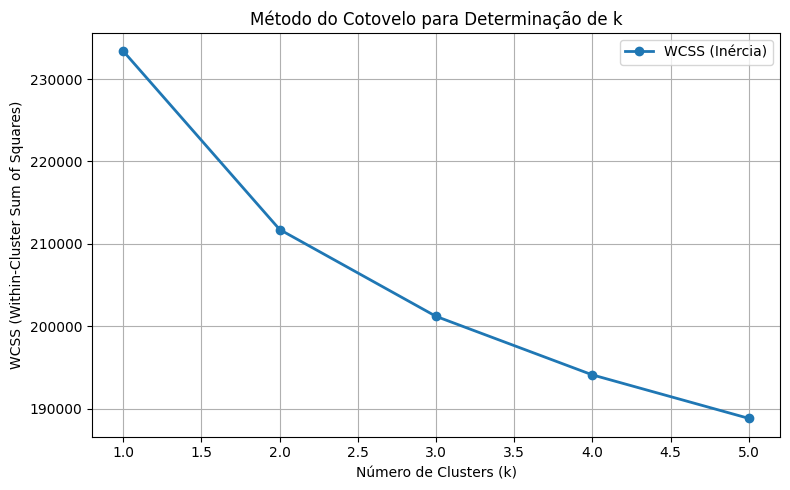

Melhor k (cotovelo): None


In [23]:
min_clusters = 1
max_clusters = 5


best_k, wcss = plot_elbow_wcss(X_sample, min_clusters, max_clusters)


**Avaliação do número de clusters com K variando de `1` a `8`**

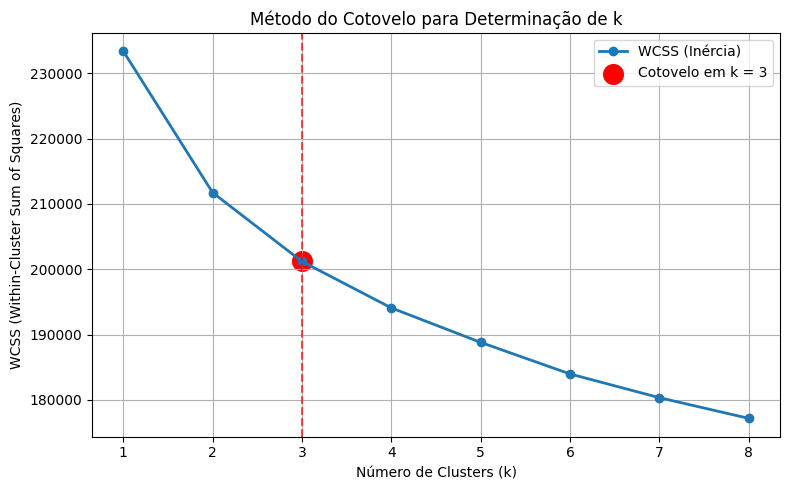

Melhor k (cotovelo): 3


In [24]:
min_clusters = 1
max_clusters = 8


best_k, wcss = plot_elbow_wcss(X_sample, min_clusters, max_clusters)


**Avaliação do número de clusters com K variando de `1` a `12`**

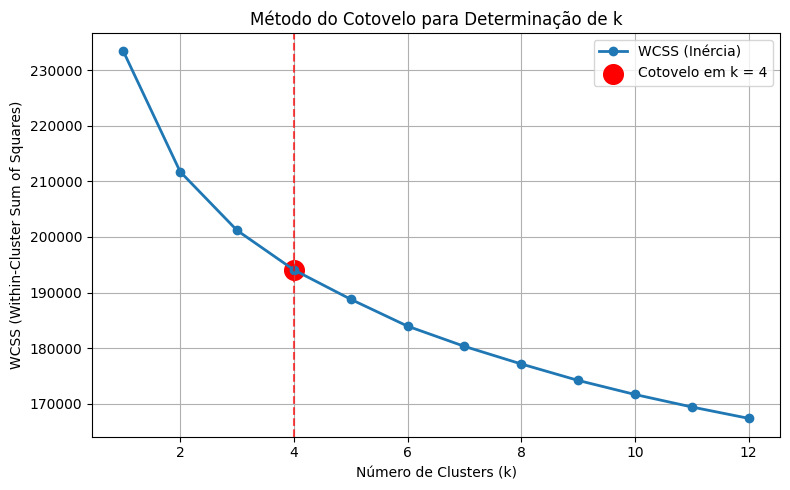

Melhor k (cotovelo): 4


In [25]:
min_clusters = 1
max_clusters = 12

best_k, wcss = plot_elbow_wcss(X_sample, min_clusters, max_clusters)


**Avaliação do número de clusters com K variando de `1` a `22`**

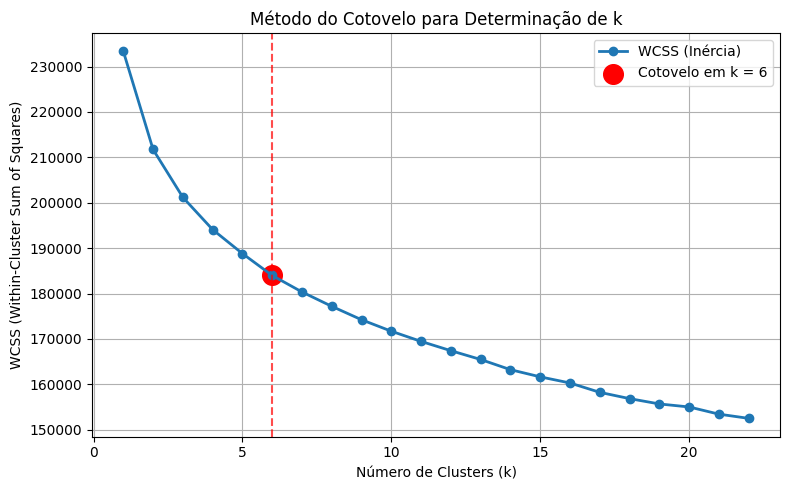

Melhor k (cotovelo): 6


In [26]:
min_clusters = 1
max_clusters = 22

best_k, wcss = plot_elbow_wcss(X_sample, min_clusters, max_clusters)

Como o `método do cotovelo` busca identificar um ponto de inflexão na curva de `WCSS`, alterações na `faixa de valores` de `k` testada podem modificar o formato da curva e, consequentemente, influenciar o valor do `k` considerado ideal. Por isso, foram realizados testes com quatro intervalos distintos:
- `k = 1-5`: Não há um cotovelo bem definido, mas visualmente `k=2` poderia ser considerado;
- `k = 1-8`: cotovelo em `k=3`;
- `k = 1-12`: cotovelo em `k=4`;
- `k = 1-22`: cotovelo em `k=6`.

Embora o objetivo prático da detecção de fraudes geralmente envolva a distinção entre `dois grupos principais` (transações fraudulentas e não fraudulentas), o algoritmo `KMeans` tende a agrupar com base em padrões gerais de similaridade nos dados. Isso explica por que valores de k maiores que 2 podem ter sido sugeridos pelo método.

#### **3.1.1.2. Silhouette Score**

Baseia-se na proximidade entre os objetos de um cluster e na distância dos objetos de um cluster ao cluster mais próximo. Os valores variam de -1 a 1. Valores próximos a 1 indicam bons agrupamentos.

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_silhouette_scores(X, min_clusters=2, max_clusters=12):
    silhouette_scores = []

    for k in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        
        score = silhouette_score(X, cluster_labels)
        silhouette_scores.append(score)

        print(f"Silhouette Score para k={k}: {score:.4f}")

    cluster_range = list(range(min_clusters, max_clusters + 1))
    best_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]


    # Plotando os resultados
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, silhouette_scores, marker='o', linewidth=2, label='Silhouette Score')
    plt.scatter(best_k, max(silhouette_scores), s=200, c='red', label=f'Melhor k = {best_k}')
    plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)

    plt.grid(True)
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Valor do Silhouette Score')
    plt.title('Silhouette Score para Determinação do Número Ideal de Clusters')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Retornar o melhor k
    print(f"\nMelhor número de clusters com base no Silhouette Score: k = {best_k}")
    return best_k


Silhouette Score para k=2: 0.0959
Silhouette Score para k=3: 0.0790
Silhouette Score para k=4: 0.0822
Silhouette Score para k=5: 0.0704
Silhouette Score para k=6: 0.0647
Silhouette Score para k=7: 0.0600
Silhouette Score para k=8: 0.0584
Silhouette Score para k=9: 0.0592
Silhouette Score para k=10: 0.0595
Silhouette Score para k=11: 0.0591
Silhouette Score para k=12: 0.0567
Silhouette Score para k=13: 0.0547
Silhouette Score para k=14: 0.0558
Silhouette Score para k=15: 0.0551
Silhouette Score para k=16: 0.0553
Silhouette Score para k=17: 0.0544
Silhouette Score para k=18: 0.0558
Silhouette Score para k=19: 0.0554
Silhouette Score para k=20: 0.0538
Silhouette Score para k=21: 0.0542
Silhouette Score para k=22: 0.0561


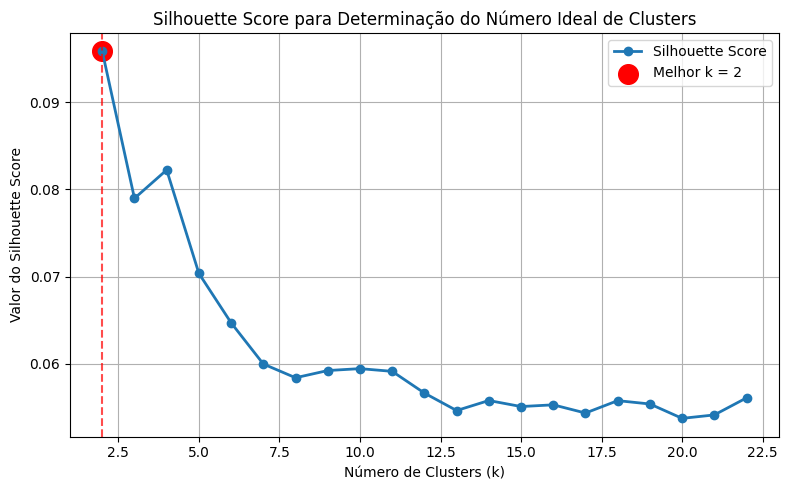


Melhor número de clusters com base no Silhouette Score: k = 2


In [28]:
best_k = plot_silhouette_scores(X_sample, min_clusters=2, max_clusters=22)


#### **3.1.1.3. Estatística GAP**

A `Estatística Gap` compara a dispersão de um agrupamento nos dados reais com a dispersão esperada em um conjunto de dados de referência aleatório, sem estrutura de cluster. Ela também é utilizada para estimar o número de grupos presentes em um conjunto de dados. Os valores variam entre 0 e infinito. Quanto maior o GAP, maior a evidência de que o agrupamento real tem estrutura melhor que o acaso.

In [29]:
import pandas as pd
import numpy as np

def optimalK(data, nrefs=3, min_clusters=2, max_clusters=12):
    gaps = []
    cluster_range = range(min_clusters, max_clusters + 1)
    all_results = []

    for k in cluster_range:
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            # respeita a distribuição e escala das variáveis originais
            mins = np.min(data, axis=0)
            maxs = np.max(data, axis=0)
            random_data = np.random.uniform(mins, maxs, size=data.shape)
            
            km = KMeans(n_clusters=k, n_init=10)
            km.fit(random_data)
            refDisps[i] = km.inertia_

        km = KMeans(n_clusters=k, n_init=10)
        km.fit(data)
        origDisp = km.inertia_

        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps.append(gap)
        all_results.append({'clusterCount': k, 'gap': gap})

    resultsdf = pd.DataFrame(all_results)
    best_k = cluster_range[np.argmax(gaps)]
    
    return best_k, resultsdf

Optimal k is:  2


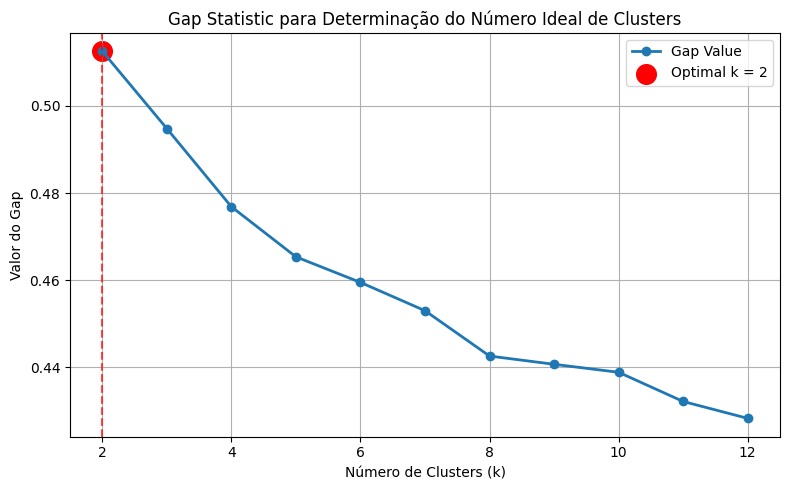

In [30]:
k, gapdf = optimalK(X_sample, nrefs=3, min_clusters=2, max_clusters=12)
print('Optimal k is: ', k)


plt.figure(figsize=(8, 5))
plt.plot(gapdf.clusterCount, gapdf.gap, marker='o', linewidth=2, label='Gap Value')
plt.scatter(k, gapdf[gapdf.clusterCount == k].gap, s=200, c='r', label=f'Optimal k = {k}')
plt.grid(True)
plt.axvline(x=k, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Valor do Gap')
plt.title('Gap Statistic para Determinação do Número Ideal de Clusters')
plt.legend()
plt.tight_layout()
plt.show()

Apesar do `Elbow Method` sugerir valores mais altos de `k` (4 ou 6) dependendo da faixa testada, tanto o `Silhouette Score` quanto a `Estatística GAP` sugerem o valor de `k = 2` como a escolha mais apropriada.

Embora as transações fraudulentas possam estar concentradas em um desses grupos, essa sugestão de `k = 2` pode não ter uma relação direta com a fraude, uma vez que o `KMeans` não conhece os rótulos reais e agrupa com base na similaridade geométrica dos dados.

### **3.1.2 Treinamento e Avaliação**

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score
)
import pandas as pd
from itertools import product

def avaliar_kmeans_variando_hiperparametros(X, y_true, 
                                             cluster_range=range(2, 11),
                                             n_init_options=[20],
                                             max_iter_options=[300],
                                             init_options = ['k-means++', 'random']):
    resultados = []

    for n_clusters, n_init, max_iter, init in product(cluster_range, n_init_options, max_iter_options, init_options):
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, init=init, random_state=42)
        y_pred = kmeans.fit_predict(X)

        silhouette = silhouette_score(X, y_pred)
        ari = adjusted_rand_score(y_true, y_pred)
        ami = adjusted_mutual_info_score(y_true, y_pred)
        fmi = fowlkes_mallows_score(y_true, y_pred)

        df = pd.DataFrame({'cluster': y_pred, 'is_fraud': y_true})
        resumo = df.groupby('cluster')['is_fraud'].agg(
            total_transacoes='count',
            total_fraudes='sum'
        )
        resumo['proporcao_fraude'] = (resumo['total_fraudes'] / resumo['total_transacoes']).round(4)
        max_proporcao = resumo['proporcao_fraude'].max()

        #A média representa a proporção de valores 1.
        proporcao_fraude_base = y_true.mean()

        # Densidade relativa
        densidade_relativa = (max_proporcao / proporcao_fraude_base).round(2)

        resultados.append({
            'n_clusters': n_clusters,
            'n_init': n_init,
            'max_iter': max_iter,
            'init': init,
            'Silhouette': silhouette,
            'ARI': ari,
            'AMI': ami,
            'FMI': fmi,
            'resumo_cluster': resumo.reset_index().to_dict(orient='list'),
            'max_proporcao_fraude': max_proporcao,
            'densidade_relativa': densidade_relativa
        })

    return pd.DataFrame(resultados)



In [32]:
df_resultados = avaliar_kmeans_variando_hiperparametros(
    X_sample, y_true,
    cluster_range=range(2, 11),
    n_init_options=[10, 20],
    max_iter_options=[100, 300],
    init_options = ['k-means++', 'random']
)

# Salvar o df_resultados com métricas
df_resultados.to_csv("../data/processed/results/fraudTrain_1pct/kmeans_resultados.csv", index=False)


In [33]:
metricas = ['Silhouette', 'ARI', 'AMI', 'FMI']

# Número de configurações que deseja exibir por métrica
top_n = 10

for metrica in metricas:
    print("\n" + "=" * 80)
    print(f"Top {top_n} configurações ordenadas por: {metrica}")
    print("=" * 80)
    
    df_ordenado = df_resultados.sort_values(by=metrica, ascending=False).head(top_n)
    display(df_ordenado[['n_clusters', 'n_init', 'max_iter', 'init', metrica, 'max_proporcao_fraude', 'densidade_relativa']])
    


Top 10 configurações ordenadas por: Silhouette


,n_clusters,n_init,max_iter,init,Silhouette,max_proporcao_fraude,densidade_relativa
0,2,10,100,k-means++,0.095857,0.0059,1.02
1,2,10,100,random,0.095857,0.0059,1.02
2,2,10,300,k-means++,0.095857,0.0059,1.02
3,2,10,300,random,0.095857,0.0059,1.02
4,2,20,100,k-means++,0.095857,0.0059,1.02
5,2,20,100,random,0.095857,0.0059,1.02
6,2,20,300,k-means++,0.095857,0.0059,1.02
7,2,20,300,random,0.095857,0.0059,1.02
20,4,20,100,k-means++,0.082240,0.0084,1.45
22,4,20,300,k-means++,0.082240,0.0084,1.45



Top 10 configurações ordenadas por: ARI


,n_clusters,n_init,max_iter,init,ARI,max_proporcao_fraude,densidade_relativa
23,4,20,300,random,0.000708,0.0099,1.71
21,4,20,100,random,0.000708,0.0099,1.71
17,4,10,100,random,0.000706,0.0099,1.71
19,4,10,300,random,0.000706,0.0099,1.71
18,4,10,300,k-means++,0.000288,0.0084,1.45
16,4,10,100,k-means++,0.000288,0.0084,1.45
20,4,20,100,k-means++,0.000288,0.0084,1.45
22,4,20,300,k-means++,0.000288,0.0084,1.45
29,5,20,100,random,0.000274,0.0101,1.75
31,5,20,300,random,0.000274,0.0101,1.75



Top 10 configurações ordenadas por: AMI


,n_clusters,n_init,max_iter,init,AMI,max_proporcao_fraude,densidade_relativa
46,7,20,300,k-means++,0.001093,0.0123,2.13
44,7,20,100,k-means++,0.001093,0.0123,2.13
71,10,20,300,random,0.001017,0.0141,2.44
69,10,20,100,random,0.001017,0.0141,2.44
65,10,10,100,random,0.001017,0.0141,2.44
67,10,10,300,random,0.001017,0.0141,2.44
23,4,20,300,random,0.000991,0.0099,1.71
21,4,20,100,random,0.000991,0.0099,1.71
19,4,10,300,random,0.000989,0.0099,1.71
17,4,10,100,random,0.000989,0.0099,1.71



Top 10 configurações ordenadas por: FMI


,n_clusters,n_init,max_iter,init,FMI,max_proporcao_fraude,densidade_relativa
0,2,10,100,k-means++,0.734708,0.0059,1.02
1,2,10,100,random,0.734708,0.0059,1.02
2,2,10,300,k-means++,0.734708,0.0059,1.02
3,2,10,300,random,0.734708,0.0059,1.02
4,2,20,100,k-means++,0.734708,0.0059,1.02
5,2,20,100,random,0.734708,0.0059,1.02
6,2,20,300,k-means++,0.734708,0.0059,1.02
7,2,20,300,random,0.734708,0.0059,1.02
15,3,20,300,random,0.575860,0.0083,1.43
13,3,20,100,random,0.575860,0.0083,1.43


**Comparativo do melhor resultado obtido por cada métrica**

|Métrica|Melhor Valor|Melhor Configuração (n_clusters)|Máxima proporção de fraude em um cluster|
|---|---|---|---|
|Silhouette|0.095857|2|0.59%|
|ARI|0.000708|4|0.99%|
|AMI|0.001093|7|1.23%|
|FMI|0.734708|2|0.59%|

In [34]:
# Ordena pelo maior valor encontrado em qualquer cluster
df_ordenado_por_fraude = df_resultados.sort_values(by='max_proporcao_fraude', ascending=False)

for idx, row in df_ordenado_por_fraude.head(5).iterrows():
    print("=" * 60)
    print(f"Configuração: n_clusters={row['n_clusters']}, n_init={row['n_init']}, "
          f"max_iter={row['max_iter']}, init='{row['init']}'")
    print(f"Máxima proporção de fraude em um cluster: {row['max_proporcao_fraude'] * 100:.2f}%.")
    
    proporcao_base = y_true.mean() * 100
    densidade = row['densidade_relativa']

    if densidade > 1.05:
        print(f"Essa proporção é ~{densidade:.2f}x maior que a proporção base de {proporcao_base:.4f}%.")
    elif  densidade < 0.95:
        print(f"Essa proporção é ~{1/densidade:.2f}x menor que a proporção base de {proporcao_base:.4f}%.")
    else:
        print(f"Essa proporção é aproximadamente igual à proporção base de {proporcao_base:.4f}%.")


    resumo_df = pd.DataFrame(row['resumo_cluster'])
    resumo_df.set_index('cluster', inplace=True)
    print(resumo_df)

Configuração: n_clusters=10, n_init=10, max_iter=100, init='random'
Máxima proporção de fraude em um cluster: 1.41%.
Essa proporção é ~2.44x maior que a proporção base de 0.5784%.
         total_transacoes  total_fraudes  proporcao_fraude
cluster                                                   
0                    1264             10            0.0079
1                    1097             10            0.0091
2                    1144              6            0.0052
3                    1413              5            0.0035
4                    1517              9            0.0059
5                    1131              7            0.0062
6                    1402              4            0.0029
7                    1695              0            0.0000
8                    1493             21            0.0141
9                     810              3            0.0037
Configuração: n_clusters=10, n_init=10, max_iter=300, init='random'
Máxima proporção de fraude em um cluster: 1.

Apesar da baixa taxa geral de fraudes na base (`0.578%`), diferentes configurações do `KMeans` com `k=10` foram capazes de identificar um cluster com proporção de fraudes de `1.41%`, o que representa aproximadamente `2,44 vezes` a proporção base.

As configurações que apresentaram esse resultado foram as seguintes:
- `n_clusters = 10`
- `n_init = 10 ou 20`
- `max_iter = 100 ou 300`
- `init = 'random'`

|Configuração|Cluster com maior proporção|Proporção de fraude|Tamanho do cluster|Razão de Proporções|
|---|---|---|---|---|
|n_clusters=10, n_init=10, max_iter=100, init='random'|Cluster 8 (1.493 transações)|1.41%|1.493|~2.44x|
|n_clusters=10, n_init=10, max_iter=300, init='random'|Cluster 8 (1.493 transações)|1.41%|1.493|~2.44x|
|n_clusters=10, n_init=20, max_iter=300, init='random'|Cluster 8 (1.493 transações)|1.41%|1.493|~2.44x|
|n_clusters=10, n_init=20, max_iter=100, init='random'|Cluster 8 (1.493 transações)|1.41%|1.493|~2.44x|


Apesar das métricas `Silhouette Score` e `Fowlkes-Mallows Index (FMI)` terem indicado um melhor resultado para configurações com `k=2`, esses agrupamentos resultaram em clusters com proporções de fraude próximas à média da base (0,59%).

Já as métricas `ARI` e `AMI`, embora tenham apresentado configurações com mais clusters, apresentaram uma maior eficácia no **isolamento de grupos com maior proporção de transações fraudulentas**.

## **3.2. Agglomerative Clustering**

In [35]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score
)
import pandas as pd
from itertools import product

def avaliar_agglomerative_clustering_variando_hiperparametros(X, y_true, 
                                             cluster_range=range(2, 11),
                                             distance_metrics = ['euclidean', 'manhattan', 'cosine'],
                                             linkage_methods = ['ward', 'complete', 'average', 'single']):
    resultados = []

    for n_clusters, metric, linkage in product(cluster_range, distance_metrics, linkage_methods):

        if linkage == 'ward' and metric != 'euclidean':
            continue

        model = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    linkage=linkage,
                    metric=metric
                )


        y_pred = model.fit_predict(X)

        silhouette = silhouette_score(X, y_pred)
        ari = adjusted_rand_score(y_true, y_pred)
        ami = adjusted_mutual_info_score(y_true, y_pred)
        fmi = fowlkes_mallows_score(y_true, y_pred)

        df = pd.DataFrame({'cluster': y_pred, 'is_fraud': y_true})
        resumo = df.groupby('cluster')['is_fraud'].agg(
            total_transacoes='count',
            total_fraudes='sum'
        )
        resumo['proporcao_fraude'] = (resumo['total_fraudes'] / resumo['total_transacoes']).round(4)
        max_proporcao = resumo['proporcao_fraude'].max()

        #A média representa a proporção de valores 1.
        proporcao_fraude_base = y_true.mean()

        # Densidade relativa
        densidade_relativa = (max_proporcao / proporcao_fraude_base).round(2)

        resultados.append({
            'n_clusters': n_clusters,
            'metric': metric,
            'linkage': linkage,
            'Silhouette': silhouette,
            'ARI': ari,
            'AMI': ami,
            'FMI': fmi,
            'resumo_cluster': resumo.reset_index().to_dict(orient='list'),
            'max_proporcao_fraude': max_proporcao,
            'densidade_relativa': densidade_relativa
        })

    return pd.DataFrame(resultados)



In [36]:
df_resultados = avaliar_agglomerative_clustering_variando_hiperparametros(
    X_sample, y_true,
    cluster_range=range(2, 11),
    distance_metrics = ['euclidean', 'manhattan', 'cosine'],
    linkage_methods = ['ward', 'complete', 'average', 'single']
)

# Salvar o df_resultados com métricas
df_resultados.to_csv("../data/processed/results/fraudTrain_1pct/agglomerative_clustering_resultados.csv", index=False)


In [37]:
metricas = ['Silhouette', 'ARI', 'AMI', 'FMI']

# Número de configurações que deseja exibir por métrica
top_n = 10

for metrica in metricas:
    print("\n" + "=" * 80)
    print(f"Top {top_n} configurações ordenadas por: {metrica}")
    print("=" * 80)
    
    df_ordenado = df_resultados.sort_values(by=metrica, ascending=False).head(top_n)
    display(df_ordenado[['n_clusters', 'metric', 'linkage', metrica, 'max_proporcao_fraude', 'densidade_relativa']])
    


Top 10 configurações ordenadas por: Silhouette


,n_clusters,metric,linkage,Silhouette,max_proporcao_fraude,densidade_relativa
6,2,manhattan,single,0.381071,0.0058,1.00
1,2,euclidean,complete,0.378481,0.0058,1.00
5,2,manhattan,average,0.378481,0.0058,1.00
2,2,euclidean,average,0.378481,0.0058,1.00
4,2,manhattan,complete,0.378481,0.0058,1.00
3,2,euclidean,single,0.378481,0.0058,1.00
13,3,euclidean,single,0.368911,0.0058,1.00
12,3,euclidean,average,0.274691,0.0476,8.23
15,3,manhattan,average,0.274691,0.0476,8.23
23,4,euclidean,single,0.272235,0.0476,8.23



Top 10 configurações ordenadas por: ARI


,n_clusters,metric,linkage,ARI,max_proporcao_fraude,densidade_relativa
32,5,euclidean,average,0.062200,0.6,103.73
52,7,euclidean,average,0.055033,0.6,103.73
42,6,euclidean,average,0.049945,0.6,103.73
35,5,manhattan,average,0.045564,1.0,172.88
45,6,manhattan,average,0.044175,1.0,172.88
55,7,manhattan,average,0.044175,1.0,172.88
62,8,euclidean,average,0.037695,0.6,103.73
82,10,euclidean,average,0.031378,0.6,103.73
72,9,euclidean,average,0.030070,0.6,103.73
76,9,manhattan,single,0.018552,0.5,86.44



Top 10 configurações ordenadas por: AMI


,n_clusters,metric,linkage,AMI,max_proporcao_fraude,densidade_relativa
32,5,euclidean,average,0.031975,0.6,103.73
35,5,manhattan,average,0.027400,1.0,172.88
45,6,manhattan,average,0.026348,1.0,172.88
55,7,manhattan,average,0.026214,1.0,172.88
42,6,euclidean,average,0.025973,0.6,103.73
52,7,euclidean,average,0.024703,0.6,103.73
82,10,euclidean,average,0.017701,0.6,103.73
62,8,euclidean,average,0.014897,0.6,103.73
76,9,manhattan,single,0.010521,0.5,86.44
72,9,euclidean,average,0.010512,0.6,103.73



Top 10 configurações ordenadas por: FMI


,n_clusters,metric,linkage,FMI,max_proporcao_fraude,densidade_relativa
9,2,cosine,single,0.994154,0.0058,1.0
6,2,manhattan,single,0.994077,0.0058,1.0
19,3,cosine,single,0.994077,0.0058,1.0
16,3,manhattan,single,0.993999,0.0058,1.0
29,4,cosine,single,0.993999,0.0058,1.0
26,4,manhattan,single,0.993999,0.0058,1.0
36,5,manhattan,single,0.993922,0.0058,1.0
39,5,cosine,single,0.993922,0.0058,1.0
49,6,cosine,single,0.993844,0.0058,1.0
46,6,manhattan,single,0.993767,0.0058,1.0


**Comparativo do melhor resultado obtido por cada métrica**

|Métrica|Melhor Valor|Melhor Configuração (n_clusters-metric-linkage)|Máxima proporção de fraude em um cluster|
|---|---|---|---|
|Silhouette|0.381071|2-manhattan-single|0.58%|
|ARI|0.062200|5-euclidean-average|60% (cluster com 5 transações)|
|AMI|0.031975|5-euclidean-average|60% (cluster com 5 transações)|
|FMI|0.994154|2-cosine-single|0.58%|

In [38]:
# Ordena pelo maior valor encontrado em qualquer cluster
df_ordenado_por_fraude = df_resultados.sort_values(by='max_proporcao_fraude', ascending=False)

for idx, row in df_ordenado_por_fraude.head(5).iterrows():
    print("=" * 60)

    print(f"Configuração: n_clusters={row['n_clusters']}, metric={row['metric']}, "
          f"linkage={row['linkage']}")
    print(f"Máxima proporção de fraude em um cluster: {row['max_proporcao_fraude'] * 100:.2f}%.")
    
    proporcao_base = y_true.mean() * 100
    densidade = row['densidade_relativa']

    if densidade > 1.05:
        print(f"Essa proporção é ~{densidade:.2f}x maior que a proporção base de {proporcao_base:.4f}%.")
    elif  densidade < 0.95:
        print(f"Essa proporção é ~{1/densidade:.2f}x menor que a proporção base de {proporcao_base:.4f}%.")
    else:
        print(f"Essa proporção é aproximadamente igual à proporção base de {proporcao_base:.4f}%.")


    resumo_df = pd.DataFrame(row['resumo_cluster'])
    resumo_df.set_index('cluster', inplace=True)
    print(resumo_df)

Configuração: n_clusters=6, metric=manhattan, linkage=average
Máxima proporção de fraude em um cluster: 100.00%.
Essa proporção é ~172.88x maior que a proporção base de 0.5784%.
         total_transacoes  total_fraudes  proporcao_fraude
cluster                                                   
0                       4              0            0.0000
1                   12918             72            0.0056
2                      21              1            0.0476
3                      18              0            0.0000
4                       2              2            1.0000
5                       3              0            0.0000
Configuração: n_clusters=5, metric=manhattan, linkage=average
Máxima proporção de fraude em um cluster: 100.00%.
Essa proporção é ~172.88x maior que a proporção base de 0.5784%.
         total_transacoes  total_fraudes  proporcao_fraude
cluster                                                   
0                   12921             72            0.

Apesar da baixa taxa geral de fraudes na base (`0.578%`), o algoritmo foi capaz de identificar clusters com `100%` de transações fraudulentas. No entanto, é importante citar que os clusters com `100%` de fraudes são muito pequenos (tamanho 2), possuindo pouca representatividade estatística. 

As configurações que produziram esses resultados foram:
- `linkage='average'`
- `metric='manhattan'`


Apesar de os clusters com maior proporção de fraude serem pequenos, é importante notar que essas mesmas configurações foram favorecidas por critérios externos de avaliação como `ARI` e `AMI`.

## **3.3 DBSCAN**

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score
)
import pandas as pd
from itertools import product
import numpy as np

def avaliar_dbscan_variando_hiperparametros(X, y_true,
                                            eps_values=[0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5],
                                            min_samples_values=[3, 5, 7],
                                            distance_metrics=['euclidean', 'manhattan', 'cosine']):
    resultados = []

    for eps, min_samples, metric in product(eps_values, min_samples_values, distance_metrics):

        model = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        y_pred = model.fit_predict(X)

        # Inclui o ruído como cluster separado (-1 já vem do DBSCAN)
        n_clusters = len(set(y_pred))  # inclui o -1 como cluster
        
        if n_clusters < 2:
            continue

        try:
            silhouette = silhouette_score(X, y_pred)
        except:
            silhouette = np.nan  # caso não consiga calcular

        ari = adjusted_rand_score(y_true, y_pred)
        ami = adjusted_mutual_info_score(y_true, y_pred)
        fmi = fowlkes_mallows_score(y_true, y_pred)

        df = pd.DataFrame({'cluster': y_pred, 'is_fraud': y_true})
        # df = df[df['cluster'] != -1]  # remove ruído

        resumo = df.groupby('cluster')['is_fraud'].agg(
            total_transacoes='count',
            total_fraudes='sum'
        )
        resumo['proporcao_fraude'] = (resumo['total_fraudes'] / resumo['total_transacoes']).round(4)
        max_proporcao = resumo['proporcao_fraude'].max() if not resumo.empty else 0.0

        proporcao_fraude_base = y_true.mean()
        densidade_relativa = (max_proporcao / proporcao_fraude_base).round(2) if proporcao_fraude_base > 0 else 0

        resultados.append({
            'eps': eps,
            'min_samples': min_samples,
            'metric': metric,
            'n_clusters': n_clusters,
            'Silhouette': silhouette,
            'ARI': ari,
            'AMI': ami,
            'FMI': fmi,
            'resumo_cluster': resumo.reset_index().to_dict(orient='list'),
            'max_proporcao_fraude': max_proporcao,
            'densidade_relativa': densidade_relativa
        })

    return pd.DataFrame(resultados)


In [40]:
df_resultados = avaliar_dbscan_variando_hiperparametros(
    X_sample, y_true,
    eps_values=[0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2, 3],
    min_samples_values=[3, 5, 7, 9],
    distance_metrics=['euclidean', 'manhattan', 'cosine']
)

# Salvar o df_resultados com métricas
df_resultados.to_csv("../data/processed/results/fraudTrain_1pct/dbscan_resultados.csv", index=False)


In [41]:
metricas = ['Silhouette', 'ARI', 'AMI', 'FMI']

# Número de configurações que deseja exibir por métrica
top_n = 10

for metrica in metricas:
    print("\n" + "=" * 80)
    print(f"Top {top_n} configurações ordenadas por: {metrica}")
    print("=" * 80)
    
    df_ordenado = df_resultados.sort_values(by=metrica, ascending=False).head(top_n)
    display(df_ordenado[['n_clusters', 'eps', 'min_samples', 'metric', metrica, 'max_proporcao_fraude', 'densidade_relativa']])
    


Top 10 configurações ordenadas por: Silhouette


,n_clusters,eps,min_samples,metric,Silhouette,max_proporcao_fraude,densidade_relativa
14,2,3.0,7,euclidean,0.129406,0.0313,5.41
15,2,3.0,9,euclidean,0.121253,0.0268,4.63
11,6,3.0,3,euclidean,0.057963,0.0398,6.88
13,3,3.0,5,euclidean,0.024349,0.0330,5.71
2,2,1.1,3,euclidean,-0.044799,0.0058,1.00
5,2,1.5,5,euclidean,-0.055440,0.0058,1.00
7,4,2.0,3,manhattan,-0.159572,0.0058,1.00
10,16,2.0,9,euclidean,-0.251989,0.0059,1.02
1,21,0.1,5,cosine,-0.264545,0.0058,1.00
3,14,1.3,3,euclidean,-0.266499,0.0058,1.00



Top 10 configurações ordenadas por: ARI


,n_clusters,eps,min_samples,metric,ARI,max_proporcao_fraude,densidade_relativa
11,6,3.0,3,euclidean,0.051864,0.0398,6.88
13,3,3.0,5,euclidean,0.045024,0.0330,5.71
14,2,3.0,7,euclidean,0.043488,0.0313,5.41
15,2,3.0,9,euclidean,0.036072,0.0268,4.63
2,2,1.1,3,euclidean,-0.000443,0.0058,1.00
5,2,1.5,5,euclidean,-0.000852,0.0058,1.00
7,4,2.0,3,manhattan,-0.001355,0.0058,1.00
3,14,1.3,3,euclidean,-0.004143,0.0058,1.00
12,19,3.0,3,manhattan,-0.004885,0.0058,1.00
0,355,0.1,3,cosine,-0.006579,0.3333,57.62



Top 10 configurações ordenadas por: AMI


,n_clusters,eps,min_samples,metric,AMI,max_proporcao_fraude,densidade_relativa
11,6,3.0,3,euclidean,0.013437,0.0398,6.88
14,2,3.0,7,euclidean,0.012421,0.0313,5.41
13,3,3.0,5,euclidean,0.011782,0.0330,5.71
15,2,3.0,9,euclidean,0.010199,0.0268,4.63
2,2,1.1,3,euclidean,-0.000231,0.0058,1.00
5,2,1.5,5,euclidean,-0.000335,0.0058,1.00
7,4,2.0,3,manhattan,-0.000652,0.0058,1.00
6,415,2.0,3,euclidean,-0.001192,0.3333,57.62
10,16,2.0,9,euclidean,-0.001602,0.0059,1.02
9,41,2.0,7,euclidean,-0.001643,0.0061,1.05



Top 10 configurações ordenadas por: FMI


,n_clusters,eps,min_samples,metric,FMI,max_proporcao_fraude,densidade_relativa
2,2,1.1,3,euclidean,0.993999,0.0058,1.00
5,2,1.5,5,euclidean,0.993767,0.0058,1.00
7,4,2.0,3,manhattan,0.993456,0.0058,1.00
3,14,1.3,3,euclidean,0.990974,0.0058,1.00
12,19,3.0,3,manhattan,0.989966,0.0058,1.00
1,21,0.1,5,cosine,0.985313,0.0058,1.00
4,53,1.5,3,euclidean,0.980038,0.0059,1.02
10,16,2.0,9,euclidean,0.975089,0.0059,1.02
11,6,3.0,3,euclidean,0.970056,0.0398,6.88
13,3,3.0,5,euclidean,0.961649,0.0330,5.71


**Comparativo do melhor resultado obtido por cada métrica**

|Métrica|Melhor Valor|Melhor Configuração (n_clusters-eps-min_samples-metric)|Máxima proporção de fraude em um cluster|
|---|---|---|---|
|Silhouette|0.129406|2-3.0-7-euclidean|3.13%|
|ARI|0.051864|6-3.0-3-euclidean|3.98%|
|AMI|0.013437|6-3.0-3-euclidean|3.98%|
|FMI|0.993999|2-1.1-3-euclidean|0.58%|

In [42]:
pd.set_option('display.max_rows', None)

# Ordena pelo maior valor encontrado em qualquer cluster
df_ordenado_por_fraude = df_resultados.sort_values(by='max_proporcao_fraude', ascending=False)

for idx, row in df_ordenado_por_fraude.head(5).iterrows():
    print("=" * 60)

    print(f"Configuração: n_clusters={row['n_clusters']}, min_samples={row['min_samples']}, "
          f"eps={row['eps']}, metric={row['metric']}")
    print(f"Máxima proporção de fraude em um cluster: {row['max_proporcao_fraude'] * 100:.2f}%.")
    
    proporcao_base = y_true.mean() * 100
    densidade = row['densidade_relativa']

    if densidade == 0:
        print(f"A densidade relativa é zero, indicando que o cluster não contém nenhuma fraude.")
    elif densidade > 1.05:
        print(f"Essa proporção é ~{densidade:.2f}x maior que a proporção base de {proporcao_base:.4f}%.")
    elif  densidade < 0.95:
        print(f"Essa proporção é ~{1/densidade:.2f}x menor que a proporção base de {proporcao_base:.4f}%.")
    else:
        print(f"Essa proporção é aproximadamente igual à proporção base de {proporcao_base:.4f}%.")


    resumo_df = pd.DataFrame(row['resumo_cluster'])
    resumo_df.set_index('cluster', inplace=True)
    print(resumo_df)

Configuração: n_clusters=355, min_samples=3, eps=0.1, metric=cosine
Máxima proporção de fraude em um cluster: 33.33%.
Essa proporção é ~57.62x maior que a proporção base de 0.5784%.
         total_transacoes  total_fraudes  proporcao_fraude
cluster                                                   
-1                  11561             72            0.0062
 0                      4              0            0.0000
 1                      5              0            0.0000
 2                      5              0            0.0000
 3                      3              0            0.0000
 4                     12              0            0.0000
 5                      9              0            0.0000
 6                      3              0            0.0000
 7                      3              0            0.0000
 8                      6              0            0.0000
 9                      3              0            0.0000
 10                     9              0           

Embora alguns clusters tenham apresentado proporções de fraude elevadas (até `33,33%`), esses agrupamentos foram compostos por apenas 3 transações, das quais apenas uma era fraudulenta, o que reduz a relevância desse resultado.

No entanto, para algumas configurações, foi identificado `ruído (cluster -1)` que continha uma proporção de fraudes entre `3,13%` e `3.98%`, o que representa até `6,88 vezes` o percentual da base de dados. Esses resultados são apresentados na tabela a seguir:

|Configuração|Cluster com maior proporção|Proporção de fraude|Tamanho do cluster|Razão de Proporções|
|---|---|---|---|---|
|eps=3.0, min_samples=3, euclidean|Cluster -1 (327 transações)|3.98%|327|~6.88x|
|eps=3.0, min_samples=5, euclidean|Cluster -1 (455 transações)|3.30%|455|~5.71x|
|eps=3.0, min_samples=7, euclidean|Cluster -1 (607 transações)|3.13%|607|~5.41x|

# **5. Comparação dos Resultados**

Abaixo segue um resumo

|-|KMeans|Agglomerative Clustering|DBSCAN|
|---|---|---|---|
|Melhor Silhouette|0.0959|**0.3811**|0.1294|
|Melhor ARI|0.0007|**0.062**|0.0518|
|Melhor AMI|0.0011|**0.0319**|0.0134|
|Melhor FMI|0.7347|**0.9941**|0.9939|

Ao avaliar o `Coeficiente de Silhueta`, que é uma métrica utilizada para avaliar a coesão e separação dos clusters, o melhor resultado foi obtido pelo `Agglomerative Clustering`, indicando agrupamentos mais bem definidos estruturalmente. 

Os demais indicadores, são métricas externoa que comparam os agrupamentos encontrados pelo algoritmo com os rótulos reais.


Abaixo segue um resumo da avaliação nos algoritmos em função da proporção de fraudes identificadas nos clusters com maior proporção de identificação de fraudes.

|-|KMeans|Agglomerative Clustering|DBSCAN|
|---|---|---|---|
|Maior proporção de fraudes identificadas em um cluster (%)|1.41%|100% (clusters pequenos)|33.33% (clusters pequenos) e 3.98% (no ruído)|
|Razão sobre a taxa base (0.578%)|~2.44x|~172.88x|~57.62x (clusters pequenos) e ~6.88x (ruído)|
|Tamanho do cluster com maior fraude|1.493 transações|2 transações|3 transações (cluster) e entre 327-607 transações (ruído)|
|Melhores métricas associadas|ARI, AMI|ARI, AMI|ARI, AMI|

